# Performative Prediction: A Case Study in Strategic Classification

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from data_prep import load_data
from strategic import best_response
from optimization import logistic_regression, evaluate_loss
import pickle

## 1) Data 

We perform our experiments on the *Give me a credit* dataset available at https://www.kaggle.com/c/GiveMeSomeCredit. The dataset contains features of individuals and an indicator varaible on whether they defaulted on a loan or not.

In [2]:
# load data
np.random.seed(0) 
X, Y, data = load_data('cs-training.csv')
n = X.shape[0]
d = X.shape[1] - 1

Define a subset of features that can be modified strategically

In [3]:
strat_features = np.array([1, 6, 8]) - 1 # for later indexing

print('Strategic Features: \n')
for i, feature in enumerate(strat_features):
    print(i, data.columns[feature + 1])

Strategic Features: 

0 RevolvingUtilizationOfUnsecuredLines
1 NumberOfOpenCreditLinesAndLoans
2 NumberRealEstateLoansOrLines


a) configure experiment

In [4]:

# problems parameters
num_iters    = 25
eps_list = [.01, 1, 100, 1000]
# eps_list = [100, 1000]
num_eps  = len(eps_list)
params = [
    {
        # define which method to run: 'RRM' or 'RGD'
        'method': 'RRM',
        # 'Exact' or 'GD'
        'opt_method': 'Exact',
        # 'Running_SubSample' or 'OneStep'
        'accumulation': 'OneStep'
    },
    {
        'method': 'RRM',
        'opt_method': 'Exact',
        'accumulation': 'Running_SubSample'
    },
    {
        'method': 'RGD',
        'opt_method': 'GD',
        'accumulation': 'OneStep'
    },
    {
        'method': 'RGD',
        'opt_method': 'GD',
        'accumulation': 'Running_SubSample'
    },
]

import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
import matplotlib.ticker as mtick
from matplotlib.ticker import FormatStrFormatter
import pickle

matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'Times New Roman'

%matplotlib inline

b) setup summary statistics

In [5]:
with open('results.pickle','rb') as h:
    results = pickle.load(h)

c) Render results

C:\Users\Manley\AppData\Local\Temp\ipykernel_19320\417897913.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b*-" (-> color='b'). The keyword argument will take precedence.
  ax.plot([i,i+offset],[lp_list_start[c][i],lp_list_end[c][i]],'b*-',color=color,linewidth=width,label=f'{method} - {accumulation_to_name_map[accumulation]}')
C:\Users\Manley\AppData\Local\Temp\ipykernel_19320\417897913.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keyword argument will take precedence.
  ax.plot([i+offset, i+1],[lp_list_end[c][i],lp_list_start[c][i+1]],'g--',linewidth=width,color=color,)
C:\Users\Manley\AppData\Local\Temp\ipykernel_19320\417897913.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b*-" (-> color='b'). The keyword argument will take precedence.
  ax.plot([i,i+offset],[lp_list_start[c][i],lp_list_end[c][

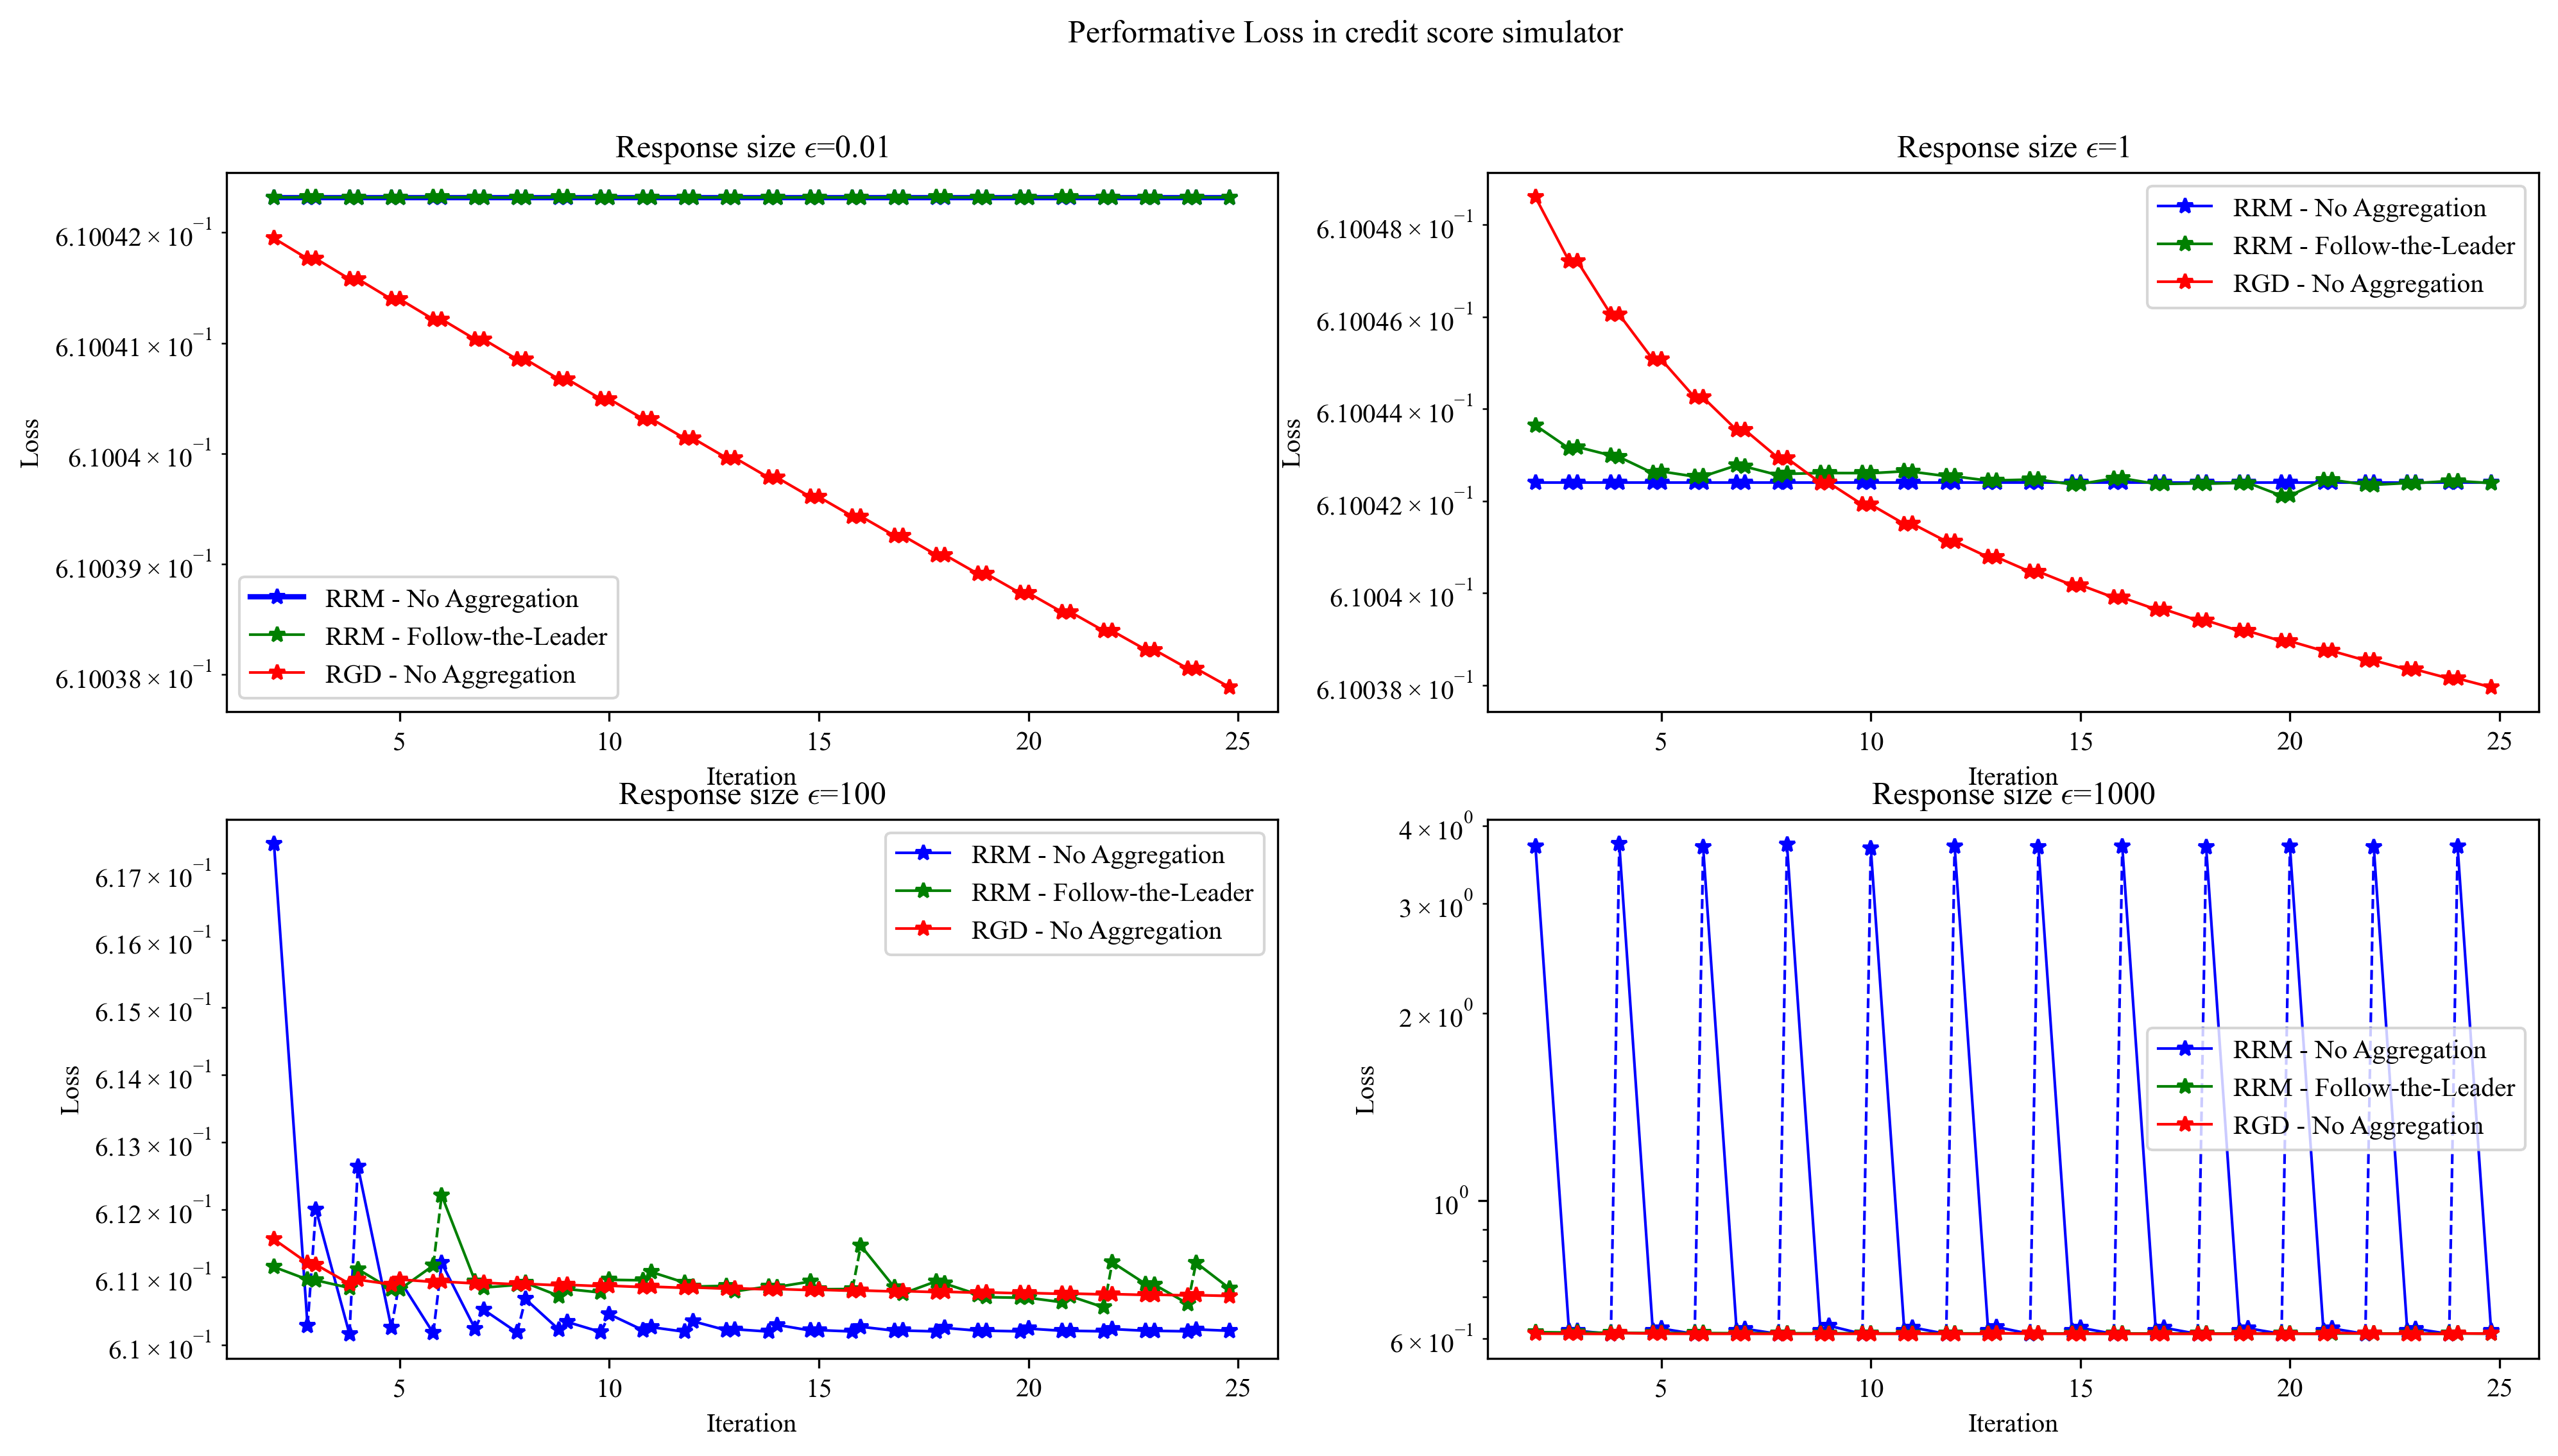

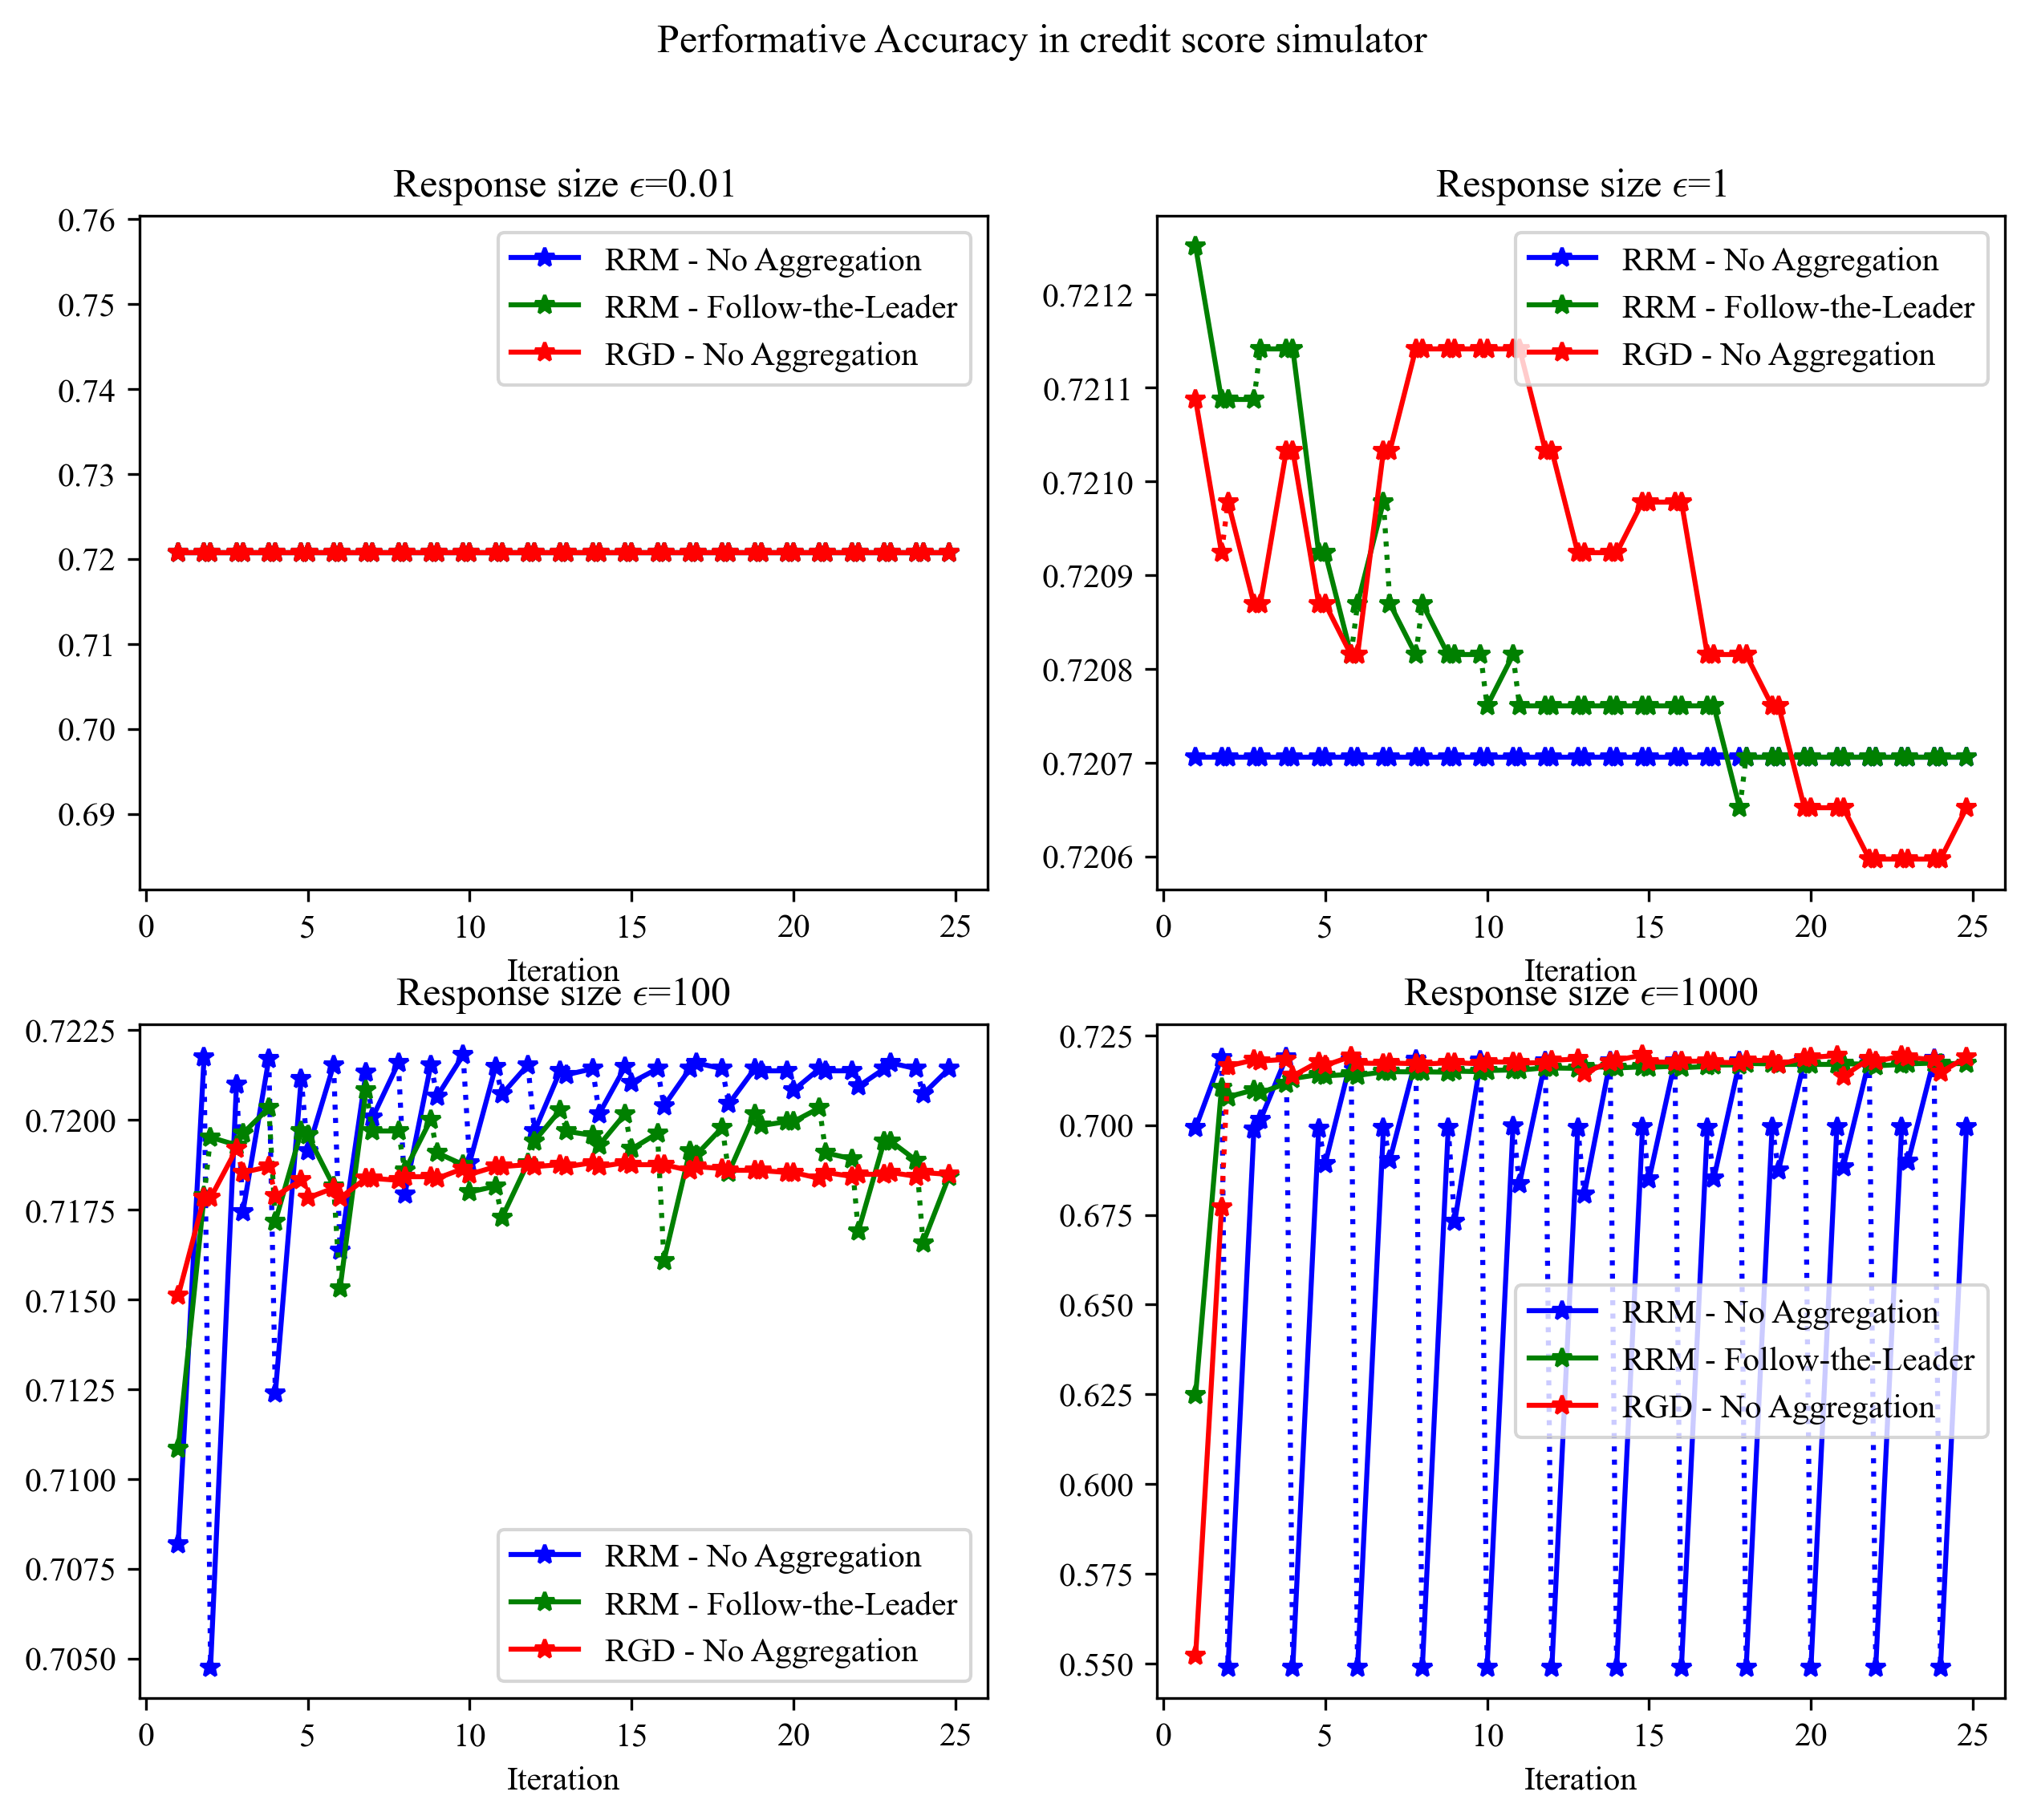

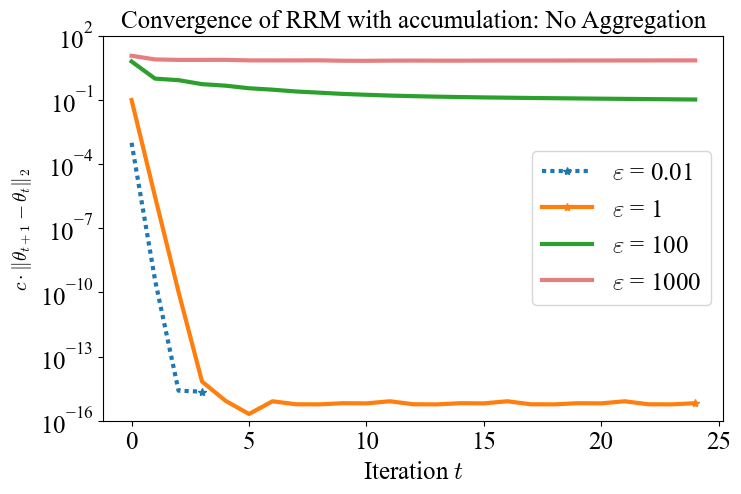

<Figure size 640x480 with 0 Axes>

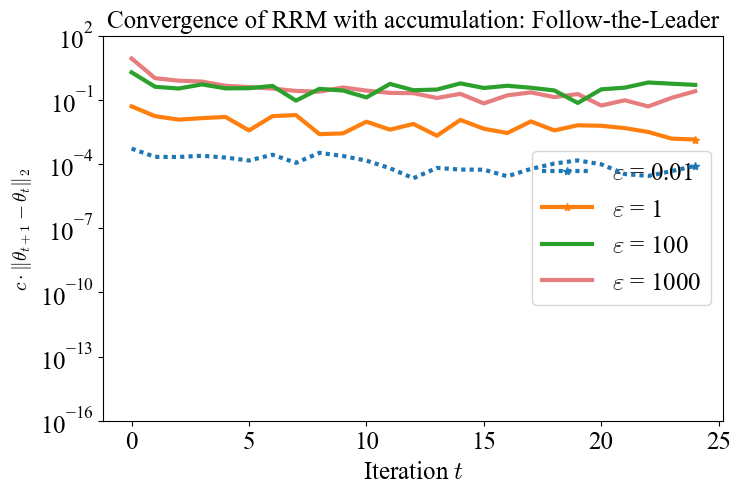

<Figure size 640x480 with 0 Axes>

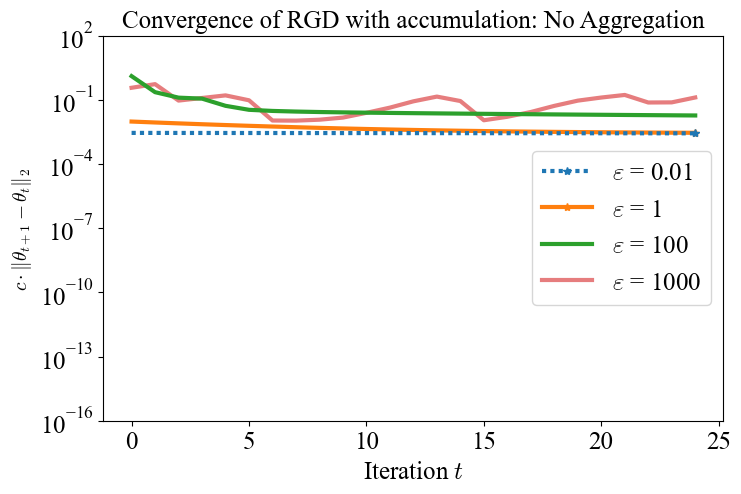

<Figure size 640x480 with 0 Axes>

In [53]:
accumulation_to_name_map = {
    'Running_SubSample': 'Follow-the-Leader',
    'OneStep': 'No Aggregation'
}

# visualize loss trajectory

fig, axes = plt.subplots(2,2, figsize=(15.5,8), dpi=300)
for c in range(num_eps):
    ax = axes[c//2,c%2]
    offset = 0.8
    ax.set_title(rf'Response size $\epsilon$={eps_list[c]}')
    # for accumulation, color in zip(['OneStep','Running_SubSample'], ['blue','red']):
    for method, opt_method, accumulation, color in [
        ('RRM','Exact','OneStep','blue'),
        ('RRM','Exact','Running_SubSample','green'),
        ('RGD','GD','OneStep','red',)
    ]:
        r = results[method][opt_method][accumulation]
        theta_list         = r['theta_list']
        theta_gaps         = r['theta_gaps']
        ll_list            = r['ll_list']
        acc_list_start     = r['acc_list_start']
        acc_list_end       = r['acc_list_end']
        lp_list_start      = r['lp_list_start']
        lp_list_end        = r['lp_list_end']
        condition_num_list = r['condition_num_list']
        gd_cutoff_list     = r['gd_cutoff_list']
        for i in range(2,num_iters):
            if i == 2:
                if color == 'blue' and c == 0:
                    width='2'
                else:
                    width='1'
                ax.plot([i,i+offset],[lp_list_start[c][i],lp_list_end[c][i]],'b*-',color=color,linewidth=width,label=f'{method} - {accumulation_to_name_map[accumulation]}')
            else:
                if color == 'blue' and c == 0:
                    width='2'
                else:
                    width='1'
                
                ax.plot([i,i+offset],[lp_list_start[c][i],lp_list_end[c][i]],'b*-',linewidth=width,color=color,)
                
            if i<num_iters-1:
                if color == 'blue' and c == 0:
                    width='2'
                else:
                    width='1'
                ax.plot([i+offset, i+1],[lp_list_end[c][i],lp_list_start[c][i+1]],'g--',linewidth=width,color=color,)

    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss') 
    ax.set_yscale('log')
    ax.legend()

plt.suptitle('Performative Loss in credit score simulator')



fig, axes = plt.subplots(2,2, figsize=(10,8), dpi=300)
for c in range(num_eps):
    # plt.figure(figsize=(8,5))
    ax = axes[c//2,c%2]
    offset = 0.8
    # plt.title(r'Performative Accuracy, response radius $\\epsilon$={}'.format(eps_list[c]))
    for method, opt_method, accumulation, color in [
        ('RRM','Exact','OneStep','blue'),
        ('RRM','Exact','Running_SubSample','green'),
        ('RGD','GD','OneStep','red',)
    ]:
        r = results[method][opt_method][accumulation]
        theta_list         = r['theta_list']
        theta_gaps         = r['theta_gaps']
        ll_list            = r['ll_list']
        acc_list_start     = r['acc_list_start']
        acc_list_end       = r['acc_list_end']
        lp_list_start      = r['lp_list_start']
        lp_list_end        = r['lp_list_end']
        condition_num_list = r['condition_num_list']
        gd_cutoff_list     = r['gd_cutoff_list']
        for i in range(1,num_iters):
            # gain of RRM step
            if i == 1:
                ax.plot([i,i+offset],[acc_list_start[c][i],acc_list_end[c][i]],'b*-',color=color,label=f'{method} - {accumulation_to_name_map[accumulation]}')
            else:
                ax.plot([i,i+offset],[acc_list_start[c][i],acc_list_end[c][i]],'b*-',color=color,)
            if i<num_iters-1:
                ax.plot([i+offset, i+1],[acc_list_end[c][i],acc_list_start[c][i+1]],'g:',color=color)

    ax.set_xlabel('Iteration')
    # ax.tick_params(labelsize=18)
    ax.set_title(rf'Response size $\epsilon$={eps_list[c]}')
    ax.legend()
    # ax.show()
    # ax.clf()
plt.suptitle('Performative Accuracy in credit score simulator')


for method, opt_method, accumulation, _ in [
    ('RRM','Exact','OneStep','blue'),
    ('RRM','Exact','Running_SubSample','green'),
    ('RGD','GD','OneStep','red',)
]:
    fig = plt.figure(figsize=(8,5))
    r = results[method][opt_method][accumulation]

    theta_list         = r['theta_list']
    theta_gaps         = r['theta_gaps']
    ll_list            = r['ll_list']
    acc_list_start     = r['acc_list_start']
    acc_list_end       = r['acc_list_end']
    lp_list_start      = r['lp_list_start']
    lp_list_end        = r['lp_list_end']
    condition_num_list = r['condition_num_list']
    gd_cutoff_list     = r['gd_cutoff_list']

    processed_theta_gaps = [[x for x in tg if x != 0.0] for tg in theta_gaps]

    for i, c in enumerate(list(range(num_eps))):
        legend_entry = '$\\varepsilon$ = {}'.format(int(eps_list[c]))
        iters_before_zero = len(processed_theta_gaps[c])

        if i == 0:
            legend_entry = '$\\varepsilon$ = {}'.format(eps_list[c])
            plt.plot(processed_theta_gaps[c],label = legend_entry, linewidth=3,  alpha=1, zorder=8,
                    markevery=[iters_before_zero - 1], marker='*', linestyle=(0, (1, 1)))
        elif i == 1:
            plt.plot(processed_theta_gaps[c],label = legend_entry, linewidth=3,  alpha=1,
                    markevery=[iters_before_zero - 1], marker='*', linestyle='solid')
        elif i == 2:
            plt.plot(processed_theta_gaps[c],label = legend_entry, linewidth=3, alpha=1, zorder=10)
        else:
            plt.plot(processed_theta_gaps[c],label = legend_entry, linewidth=3, alpha=.6)



    plt.title('Convergence of {} with accumulation: {}'.format(method, accumulation_to_name_map[accumulation]), fontsize=18)
    plt.xlabel('Iteration $t$',fontsize=18)
    plt.ylabel(r'$c \cdot \|\theta_{t+1} - \theta_{t}\|_2 $', fontsize=14)
    plt.yscale('log')
    plt.ylim([10e-17,10e1])
    plt.tick_params(labelsize=18)
    plt.legend(loc='center right', fontsize=18)
    plt.show()
    plt.clf()
